In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from fbprophet import Prophet

In [3]:
train_features = pd.read_csv('dengue_features_train.csv')

train_labels = pd.read_csv('dengue_labels_train.csv')

test_features = pd.read_csv('dengue_features_test.csv')

In [14]:
# import labels to the training data set - to make it prophet compatible

train_features['total_cases'] = np.log(train_labels['total_cases']+1)

prophet_data = train_features[[ 'city', 'week_start_date', 'total_cases']]

In [6]:
prophet_data.head()

,city,week_start_date,total_cases
0,sj,4/30/1990,1.386294
1,sj,5/7/1990,1.609438
2,sj,5/14/1990,1.386294
3,sj,5/21/1990,1.098612
4,sj,5/28/1990,1.791759


In [15]:
# Seperate data for San Juan
sj_train = prophet_data[prophet_data['city'] == 'sj'].drop('city', axis=1)
sj_test = test_features[test_features['city'] == 'sj'].drop('city', axis=1)

# # Separate data for Iquitos
iq_train = prophet_data[prophet_data['city'] == 'iq'].drop('city', axis=1)
iq_test = test_features[test_features['city'] == 'iq'].drop('city', axis=1)


In [6]:
sj_train.head()

,week_start_date,total_cases
0,4/30/1990,4
1,5/7/1990,5
2,5/14/1990,4
3,5/21/1990,3
4,5/28/1990,6


In [7]:
# # Shift every  train data column down by n rows

# sj_train['total_cases']= sj_train['total_cases'].shift(7)
# iq_train['total_cases']= iq_train['total_cases'].shift(7)


In [8]:
sj_train.head()

,week_start_date,total_cases
0,4/30/1990,1.386294
1,5/7/1990,1.609438
2,5/14/1990,1.386294
3,5/21/1990,1.098612
4,5/28/1990,1.791759


In [9]:
# as per Prophet rules
#time feature ds and the values to predict y

In [16]:
sj_train.columns = ['ds',  'y']
iq_train.columns = ['ds',  'y']

In [26]:
def create_forecast2(train_data, test_data, num, flex):
    
    prophet = Prophet(n_changepoints = num, changepoint_prior_scale=flex, 
                            daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True).add_seasonality(
                                                    name = "quaterly", period = 365.25/4, fourier_order = 5)
    
    prophet.fit(train_data)
    
    future_frame = prophet.make_future_dataframe(
        periods=len(test_data), 
        freq='W')
    
    forecast = prophet.predict(future_frame)
    
    prophet.plot(forecast)
    
    forecast = forecast[['ds','yhat']].yhat\

    return forecast[len(train_data):]

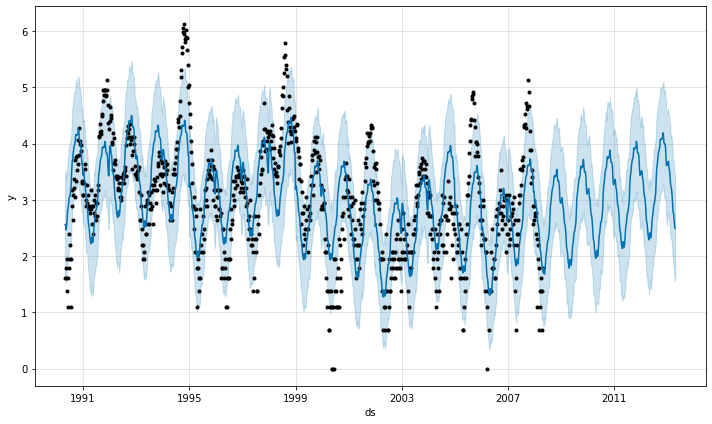

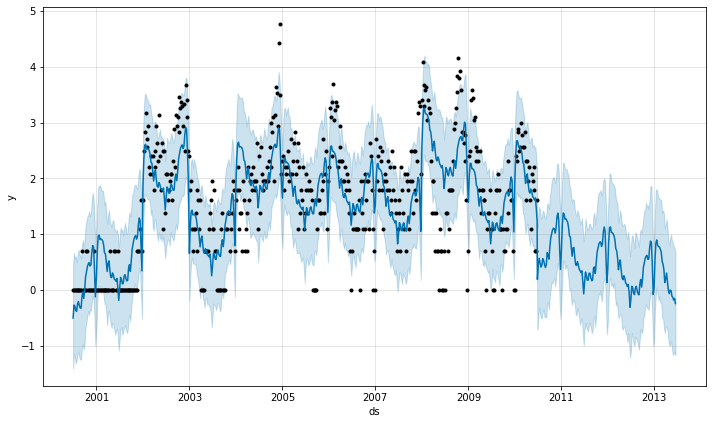

In [27]:
forecast_sj = create_forecast2(sj_train, sj_test, 20, 0.05)
forecast_iq = create_forecast2(iq_train, iq_test, 20, 0.05)

# creating output

In [28]:
forecast_sj

936     1.707546
937     1.772310
938     1.679221
939     1.689335
940     1.804215
941     1.952791
942     2.051890
943     2.098880
944     2.222055
945     2.271307
946     2.289863
947     2.373014
948     2.434225
949     2.644744
950     2.877295
951     2.945252
952     3.037156
953     3.132001
954     3.196745
955     3.231063
956     3.259518
957     3.388386
958     3.429798
959     3.402746
960     3.432656
961     3.422342
962     3.500421
963     3.545080
964     3.402571
965     3.332666
          ...   
1166    4.079981
1167    4.079634
1168    4.072082
1169    4.094204
1170    4.092536
1171    4.194259
1172    4.176953
1173    4.028439
1174    3.996357
1175    3.999489
1176    3.952830
1177    3.783186
1178    3.615590
1179    3.612827
1180    3.620639
1181    3.669501
1182    3.687231
1183    3.570429
1184    3.526800
1185    3.439601
1186    3.280046
1187    3.234507
1188    3.189181
1189    3.091900
1190    2.925670
1191    2.786451
1192    2.764138
1193    2.6564

In [55]:

def create_submission(forecast_sj, forecast_iq, sub_name):
    
    test_index = test_features[['city', 'year', 'weekofyear']]
    
    output = pd.concat([round(np.exp(forecast_sj))-1, round(np.exp(forecast_iq))-1])\
        .reset_index().drop(['index'], axis=1)
        
    output.columns = ['total_cases']
    
    pd.concat([test_index, output], axis=1)\
        .set_index(['city']).to_csv(sub_name + '.csv')

In [56]:
create_submission(forecast_sj, forecast_iq, 'Log_final')